In [1]:
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import pathlib

In [2]:
dataset_path = "/kaggle/input/inaturalist-12k/inaturalist_12K/"

In [3]:
def data_generation(data_augmentation=False):
    # Mean and standard deviation values
    mean = [0.4708, 0.4596, 0.3891]
    std = [0.1951, 0.1892, 0.1859]

    # Define transformations for training and testing data
    if data_augmentation:
        train_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
        ])
    else:
        train_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
        ])

    test_transform = transforms.Compose([
        transforms.Resize((256, 256)), 
        transforms.ToTensor(), 
        transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
    ])

    return train_transform, test_transform

In [4]:
train_transform, test_transform = data_generation(data_augmentation=False)
train_dataset = datasets.ImageFolder(root = dataset_path + "train", transform=train_transform)
test_dataset = datasets.ImageFolder(root = dataset_path + "val", transform=test_transform)

In [5]:
# transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

In [6]:
# train_dataset = datasets.ImageFolder(root = dataset_path + "train", transform=transform)
# test_dataset = datasets.ImageFolder(root = dataset_path + "val", transform=transform)

In [7]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

In [8]:
train_data, val_data = data_utils.random_split(train_dataset, [train_size, val_size])

In [9]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [10]:
def get_mean_and_std(loader):
    mean = 0
    std = 0
    total_images_count = 0
    for images, _ in loader:
        images_count_in_a_batch = images.size(0)
        images = images.view(images_count_in_a_batch, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += images_count_in_a_batch
    mean /= total_images_count
    std /= total_images_count
    return mean, std

In [11]:
# get_mean_and_std(train_loader)

In [12]:
# class_names = ['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']
classpath = pathlib.Path(dataset_path + "train")
class_names = sorted([j.name.split('/')[-1] for j in classpath.iterdir()])

In [13]:
print(class_names)

['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']


In [14]:
def show_images(images, labels):
    plt.figure(figsize=(10, 10))
    for i in range(len(images)):
        plt.subplot(6, 6, i + 1)
        plt.imshow(np.transpose(images[i], (1, 2, 0)))  # Transpose the image tensor to (height, width, channels) for displaying
        plt.title(f"{class_names[labels[i]]}")
        plt.axis('off')
    plt.subplots_adjust(wspace=0.4, hspace=0.5)
    plt.show()

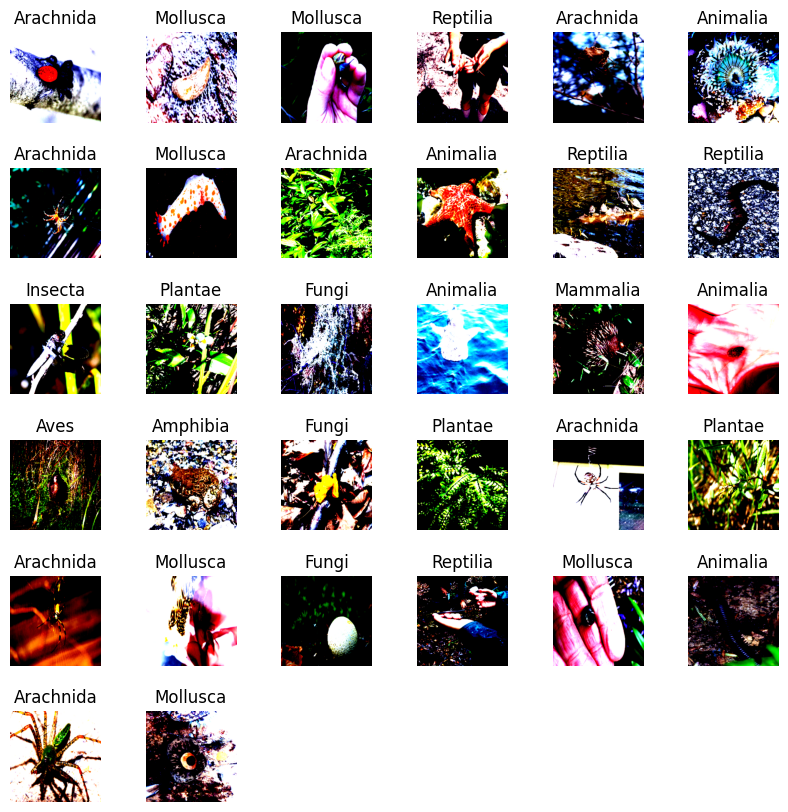

In [15]:
for images, labels in train_loader:
  show_images(images, labels)
  break

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [17]:
class ClassCNN(nn.Module):
  def __init__(self, num_filters, activation_function, filter_multiplier, filter_sizes, 
               dropout, batch_norm, dense_size, num_classes, image_size=256):
    super(ClassCNN, self).__init__()
        
    # Defining convolution layers
    layers = []
    activation = getattr(nn, activation_function)()
    initial_num_filters = num_filters
    
    for i, filter_size in enumerate(filter_sizes):
        if i == 0:
            layers.append(nn.Conv2d(in_channels=3, out_channels=initial_num_filters, kernel_size=filter_size))
        else:
            num_filters = int(initial_num_filters * (filter_multiplier ** i))
            layers.append(nn.Conv2d(in_channels=initial_num_filters, out_channels=num_filters, kernel_size=filter_size))
            initial_num_filters = num_filters
            
        if batch_norm == True:
            layers.append(nn.BatchNorm2d(num_filters))
            
        layers.append(activation)
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    
    self.features = nn.Sequential(*layers)
    
    # Calculate the size of the feature maps after convolution and pooling
    final_feature_map_size = image_size
    for filter_size in filter_sizes:
        final_feature_map_size = (final_feature_map_size - filter_size + 1) // 2

        
    # Defining maxpooling layer
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    # Defining fully connected layer
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(num_filters * final_feature_map_size * final_feature_map_size, dense_size)
    self.dropout = nn.Dropout(dropout)
    self.fc2 = nn.Linear(dense_size, num_classes)


  def forward(self, x):
    x = self.features(x)  # Apply convolutional and pooling layers
    x = self.flatten(x)   # Flatten the feature maps into a 1D tensor
    x = nn.functional.relu(self.fc1(x))  # Apply ReLU activation to the first fully connected layer
    x = self.dropout(x)   # Apply dropout regularization
    x = nn.functional.softmax(self.fc2(x), dim=1)  # Apply softmax activation to the output layer
    return x

In [18]:
model = ClassCNN(num_filters=32, activation_function='ReLU', filter_multiplier=1,
                  filter_sizes=[3, 3, 3, 3, 3], dropout=0.2, batch_norm=True,
                  dense_size=64, num_classes=10, image_size=256)
model.to(device)
input_data = torch.randn(1, 3, 256, 256)  # Example input data with batch size 1 and 3-channel images
input_data = input_data.to(device)
# Forward pass
output_probs = model(input_data)

print(output_probs)  # Print the predicted class probabilities

tensor([[0.0786, 0.1447, 0.0692, 0.0423, 0.0752, 0.3127, 0.0664, 0.0409, 0.0852,
         0.0848]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


In [19]:
# Stride = S -> 1 (default)
# Padding = P -> 0
num_filters = 5                   # no. of filters = K
filter_size = 3                   # filter size = F x F
conv_activation = 'relu'          # activation function for convolution layer
dense_layer_output = 512          # no. of outputs in dense layer
# filter_org = 2

In [20]:
model = ClassCNN(num_filters=32, activation_function='ReLU', filter_multiplier=1,
                  filter_sizes=[3, 3, 3, 3, 3], dropout=0.2, batch_norm=True,
                  dense_size=64, num_classes=10, image_size=256)
model.to(device)

ClassCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (13): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): MaxPool2d(kernel_size=2, stride=2, padding

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


ClassCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (13): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): MaxPool2d(kernel_size=2, stride=2, padding

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 1

total_correct = 0
total_samples = 0

for epoch in tqdm(range(num_epochs)):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    total_correct = 0
    total_samples = 0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the parameters
        
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = total_correct / total_samples
    print(f"Epoch [{epoch+1}/{num_epochs}], Accuracy: {epoch_accuracy * 100:.2f}, Loss: {epoch_loss:.4f}")

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1/1], Accuracy: 18.95, Loss: 2.2490


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 1

# Set model to training mode
model.train()

# Number of iterations (batches) to train on
num_iterations = 1

# Training loop
for epoch in range(num_iterations):
    for inputs, labels in tqdm(train_loader):
        # Move inputs and labels to the appropriate device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Print or log loss
        print(f'Loss: {loss.item()}')

        # Break out of the loop after processing the first batch
        break

  0%|          | 0/250 [00:00<?, ?it/s]

Loss: 2.1829993724823
